# Statistical Outlier Detection

In [1]:
# Load data and create the dataframe that we need for processing going forward
import pyspark
from pyspark import SparkContext, SparkConf

In [2]:
# set some spark conf
spark_conf = SparkConf() \
    .setAppName("statistical_outlier_detection") \
    .set("spark.driver.memory", "12g") \
    .setMaster('local[*]')

In [3]:
sc = SparkContext(conf = spark_conf)
from pyspark.sql import SparkSession
spark = SparkSession(sc).builder.getOrCreate()#.config("spark.driver.cores", "4")

# Build core dataframe

We will do all our analysis off of this frame

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql import *

def get_object(s):
    splitted = s.split("/")
    return splitted[-1]

getobject_udf = udf(get_object, StringType())

def get_prefix(s):
    splitted = s.split("/")
    prefix = "/".join(splitted[0:-1])
    return prefix

getprefix_udf = udf(get_prefix, StringType())

In [8]:
txt = spark.read.parquet('data/*')

txt2 = txt \
  .filter( txt.key.startswith("dmp") ) \
  .select("requesttimestamp", "operation", "turnaroundtime", "totaltime", \
                  "objectsize", "bytessent", getobject_udf("key").alias("object"), \
                  getprefix_udf("key").alias("prefix"))

# Statistical Tail Tests

First we have to build distributions for the things that we are interested in. I will just build a normal distribution per prefix for now. In actual fact we would need to consider: 
- Number of samples per prefix
- The best type of distribution on a pre prefix level
- Should we be doing some sort of rolling window on the distribution fit?

In [69]:
# return schema for my udaf
from pyspark.sql.types import *
from pyspark.sql.functions import collect_list

norm_dist_schema = StructType([
    StructField("mean", FloatType(), True),
    StructField("std", FloatType(), True),
    StructField("shapiro-statistic", FloatType(), True),
    StructField("shapiro-probability", FloatType(), True),
])

# the core udaf
import numpy as np
from scipy.stats import beta, norm

def fit_norm_dist(s):
    # flatten the numpy 
    number_np = np.array(s).flatten()
    # normal fit test
    # this doesn't always work due to too few datapoints in our test snippet
    try:
        shapiro_test_result = scipy.stats.shapiro(np.array(number_np, dtype=float))
        test_stat = shapiro_test_result.statistic
        test_pvalue = shapiro_test_result.pvalue
    except ValueError:
        test_stat, test_pvalue = -1, -1
    # run the fit and get the fit params
    
    try:
        mean,std = norm.fit(np.array(number_np, dtype=float))
    except ValueError:
        mean, std = 0,0
        
    return (float(mean), float(std), float(test_stat), 
            float(test_pvalue))

normfit_udf = udf(fit_norm_dist, norm_dist_schema)

In [70]:
distribution_frame = txt2 \
                        .repartition("prefix") \
                        .groupBy("prefix") \
                        .agg(collect_list("totaltime").alias("distfit")) \
                        .withColumn("distfit", normfit_udf("distfit").alias("normfit"))

In [74]:
txt2.groupBy("prefix").count().sort("count").collect()

[Row(prefix='dmp/rawcleansed/rc_sap_ecc_spr/internal/ZPM_PLANT_POS01/structured', count=1),
 Row(prefix='dmp/rawcleansed/rc_visionlink_minaus/internal/engineparameters_av/structured/engineparameters_av.parquet/.hive-staging_hive_2020-06-12_23-53-20_204_8306446761861732503-2/-ext-10000/_temporary/0/_temporary/attempt_20200612235324_0057_m_000002_0/part_key%253D2020164/part-00002-8c6f8c9e-e9b2-42bd-989a-faadc064dba4.c000', count=1),
 Row(prefix='dmp/rawcleansed/rc_aurizon_bma/internal/wheelbearingtemp_axle_av/structured/wheelbearingtemp_axle_av.parquet/.hive-staging_hive_2020-06-12_23-34-47_283_7969026043177373856-1/-ext-10000/_temporary/0/_temporary/attempt_20200612233451_0103_m_000000_0/part_key%253D2020164/part-00000-932fd1d1-fe04-4496-aa4f-bad5f6ea0f94.c000', count=1),
 Row(prefix='dmp/rawcleansed/rc_datalogger_waio/confidential/mac_can/structured/mac_can/_temporary/0/_temporary/attempt_20200612231526_0027_m_000006_0/part-00006-43e4a438-97ca-4ebc-ba04-d2f6d43cb0a7-c000.snappy.parquet

In [72]:
distribution_frame.take(10)

[Row(prefix='dmp/config/edhfs/transformationservices/edh_cim_audit/META_AUDIT_CIM_RUNLOG_BASE/.hive-staging_hive_2020-06-12_23-17-12_963_7371641359653212284-1/-ext-10000/_temporary', distfit=Row(mean=9.199999809265137, std=1.600000023841858, shapiro-statistic=0.893924355506897, shapiro-probability=0.3772219121456146)),
 Row(prefix='dmp/conformed/cim/cim_int_models/INT_FLAT_WEARANALYSIS/.hive-staging_hive_2020-06-12_23-47-56_879_55422190886541361-1/-ext-10000/_temporary/0/_temporary/attempt_20200612234857_0085_m_000089_0/loaddate_partition%253D2020-06-12/part-00089-bae25fc0-ff15-46b5-b50e-f643ea7e36b2.c000', distfit=Row(mean=11.0, std=0.0, shapiro-statistic=-1.0, shapiro-probability=-1.0)),
 Row(prefix='dmp/conformed/cim/cim_int_models/INT_FLAT_WEARANALYSIS/.hive-staging_hive_2020-06-12_23-51-32_124_701873643320267234-1/-ext-10000/_temporary/0/_temporary/attempt_20200612235234_0115_m_000002_0', distfit=Row(mean=11.0, std=0.0, shapiro-statistic=-1.0, shapiro-probability=-1.0)),
 Row(pref

In [60]:
# join the normal frame with this dist frame on prefix then see if the total time is an outlier
merged_frame = txt2 \
  .filter(txt2.totaltime.isNotNull()) \
  .join(distribution_frame, on=['prefix'], how='left') \
  .select("requesttimestamp", "prefix", "totaltime", "distfit").take(3)

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 223, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 212, in _batched
    for item in iterator:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in mapper
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in <genexpr>
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 88, in <lambda>
    return lambda *a: toInternal(f(*a))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-55-c4183260469d>", line 20, in fit_norm_dist
  File "/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py", line 1670, in shapiro
    raise ValueError("Data must be at least length 3.")
ValueError: Data must be at least length 3.


In [52]:
# quickly sample some values
import scipy
vector = txt2.select("totaltime").take(100)
flat_vec = np.array(vector).flatten()
fits = norm.fit(np.array(flat_vec, dtype=float))
# shapiro test to see if the data was drawn from a normal dist
shapiro_test_result = scipy.stats.shapiro(np.array(flat_vec, dtype=float))

# using ks test to check different distributions
# we need to specify the parameters of the norm cdf for the kstest to work properly
KS_Test_result = scipy.stats.kstest(np.array(flat_vec, dtype=float), 'expon')

In [53]:
shapiro_test_result.pvalue

1.1369627959787907e-15

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

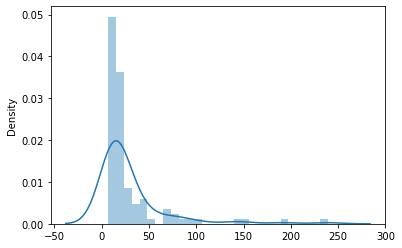

In [41]:
# plot the random vars
import seaborn as sns
%matplotlib inline
sns.distplot(np.array(flat_vec, dtype=float))

In [ ]:
# run some stat tests against the dataframes
# build the spark udaf to do this
def check_outlier(value, norm_dist_params):
    
    return answer